### Add Fumehood Data
This notebook queries raw data from WebCTRL, calculates fumehood energy and sash position data, and adds this data into Steve's SQL database.

In [1]:
import random
import time
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import tz
import matplotlib.pyplot as plt

### Utility Functions
These functions define the WebCTRL query and help parse that data into a meaningful format.

In [2]:
def create_tuple(response):
    response_data = response.json()
    response_datum = response_data[0]
    response_target = response_datum['target']
    response_datapoints = response_datum['datapoints']
    tuple_array = [tuple(x) for x in response_datapoints]
    npa = np.array(tuple_array, dtype=[
        ('value', np.double), ('ts', 'datetime64[ms]')])
    return npa

def fume_query(target,server, start,end):
  url = "https://ypsu0n34jc.execute-api.us-east-1.amazonaws.com/dev/query" #WebCTRL
  data = {
      "range": {
        "from": start,
        "to": end,
      },
      "targets": [
        {
          "payload": {
            "schema": server,
          },
          "target": target
        }
      ],

    }
  request = requests.post(url, json=data)
  print(request)
  # print(request.json())
  return create_tuple(request)


def query_to_list(point, server, start, end):
    master = fume_query(point, server, start, end)

    list = pd.Series(data=[i[0] for i in master], index=[i[1] for i in master])
    # print("\n", point, "\n", list)

    list = list[~list.index.duplicated()]
    # print("\n", point, " new\n", list)

    return list

### Metrics Functions
These functions calculate the metrics we want (time sash open and energy usage) from the raw WebCTRL data

In [4]:
def total_time_sash_open(sash_point, occ_point, server, start, end, is_occupied):
  sash_list = query_to_list(sash_point, server, start, end)
  occ_list = query_to_list(occ_point, server, start, end)

  df = pd.concat([sash_list, occ_list], axis=1)
  df.columns = ["sash", "occ"]
  # display(df)

  time_interval = df.index[1].minute - df.index[0].minute
  # print("Time interval", time_interval)

  # from running the above on a large time difference, 1.2 inches is the most common smallest value
  df["time_open_mins"] = np.where((df["sash"] > 1.2), time_interval, 0)

  df = df.dropna()
  df.index = df.index.map(lambda x: x.to_pydatetime().replace(tzinfo=tz.tzutc()).astimezone(tz.tzlocal()))
  # display(df)

  df = df[df['occ']==int(is_occupied)]
  # display(df)

  df = df.groupby(pd.Grouper(freq='60Min', label='right')).sum()
  df.index = df.index.strftime('%s').astype("int")
  display(df)

  return df["time_open_mins"]

In [5]:
# Arguments: CFM Point, Sash Point, Occ Point, Internal Temp Point, External Temp Point, Server Name, Start Time, End Time
# Returns: Total energy from hume hood, aggregated by hour.

# A switch in the energy calculations that allows us to avoid issues between times of years where it is hotter/colder outside.
def coldorhot(cfm, external, internal, time_interval):
    if external<=internal:
        #sensible heating equation
        return 1.08 * cfm * (internal - external) / (60 / time_interval)
    if external>internal:
        #enthalpy of air
        return 0.24 * cfm /13.333 * 60 * (external - internal) / (60 / time_interval)

def total_energy(cfm_point, sash_point, occ_point, internal_temp_point, external_temp_point, server, start, end, is_occupied):
  #external_temp_master = outside_temp(start,end)
  cfm_list = query_to_list(cfm_point, server, start, end)
  sash_list = query_to_list(sash_point, server, start, end)
  occ_list = query_to_list(occ_point, server, start, end)
  internal_temp_list = query_to_list(internal_temp_point, server, start, end)
  external_temp_list = query_to_list(external_temp_point, server, start, end)

  df = pd.concat([cfm_list, sash_list, occ_list, internal_temp_list, external_temp_list], axis=1)
  df.columns = ["cfm", "sash", "occ", "internal_temp", "external_temp"]
  display(df)

  df["external_temp"] = df["external_temp"].interpolate()
  display(df)
  
  time_interval = df.index[1].minute - df.index[0].minute

  df['BTU'] = df.apply(lambda df: coldorhot(df['cfm'], df['external_temp'], df['internal_temp'], time_interval=time_interval), axis=1)
  df.index = df.index.map(lambda x: x.to_pydatetime().replace(tzinfo=tz.tzutc()).astimezone(tz.tzlocal()))
  display(df)

  df = df[df['occ']==int(is_occupied)]

  df = df.groupby(pd.Grouper(freq='60Min', label='right')).sum()
  df.index = df.index.strftime('%s').astype("int")
  display(df)

  return df["BTU"]

### Insert into Database Function
This function takes in the name of a "pseudo point" and inserts the relevant data into Steve's SQL database.

In [3]:
# the x-api-key is the secret authentication to allow posting updates
headers = {"x-api-key": "LfSpEZ3woOuljzb2EAg0"}
# the endpoint URL for trend updates
TREND_API_URL = "https://7zhs2wplt9.execute-api.us-east-1.amazonaws.com/dev/trend"
# time in seconds that the request will timeout if no response is received.
# the API will only run for 6 seconds, so if it can't process
# the data posted in that amount of time it will fail.
API_TIMEOUT = 30

# timestamps
now = int(time.time())
last_hour = now - now % 3600
start_time = last_hour - (3600 * 6)

def insert_into_database(pseudo_point, data):
    # data = [compute_value(point, ts) for ts in range(start_time, last_hour, 3600)]
    data = np.fliplr(data.reset_index().to_numpy()).tolist()
    print(data)

    json_obj = {"object_name": pseudo_point, "data": data }
    # e.g.
    # { "object_name": "Biotech.GroundFloor.Lab_g54.Hood_1.energy.occ",
    # "data": [[0, 1681462800], [0, 1681466400], [0, 1681470000], [4.430475, 1681473600]],
    # }
    req_start = time.time()
    response = requests.post(TREND_API_URL, json=json_obj, headers=headers, timeout=API_TIMEOUT)
    req_end = time.time()
    r = response.json()
    print(f"""received status_code:{response.status_code} msg:{r.get('message', None)}
    rows:{r.get('affectedRows', None)} duplicates:{r.get('duplicates', None)} 
    for point:{pseudo_point} with id:{r.get('obj_id', None)} in {req_end-req_start:.3f} seconds.""")

### Insert into Database
This cell actually runs the code to insert the data processed above into Steve's SQL database

TODO
1. Load the namingconvention.csv to obtain the structure of biotech along with all points
2. For each row (fume hood) of the csv, pass the point names into the queries.  For example, pass the point names for the current hood to calculate a total_time_sash_open for that hood (do this for occ and unocc).  Do this for both the sash open and energy metrics.
3. After doing this, also for each row, insert the data into Steve's database using the correct pseudo-point name (the last four rows of the csv)

- Start this at the beginning of 2023


In [6]:
sash_data_occ = total_time_sash_open(sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
                                     occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
                                     server="biotech_main",
                                     start=str(datetime(2023, 1, 1)),
                                     end=str(datetime.now()),
                                     is_occupied=True)

sash_data_unocc = total_time_sash_open(sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
                                       occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
                                       server="biotech_main",
                                       start=str(datetime(2023, 1, 1)),
                                       end=str(datetime.now()),
                                       is_occupied=False)

energy_data_occ = total_energy(cfm_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hoodvalve_flow/trend_log",
                               sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
                               occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
                               internal_temp_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log",
                               external_temp_point="#biotech/ground_flr_mech/building_hydronic_heating_syatems/reheat_heat_exchanger/oat",
                               server="biotech_main",
                               start=str(datetime(2023, 1, 1)),
                               end=str(datetime.now()),
                               is_occupied=True)

energy_data_unocc = total_energy(cfm_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hoodvalve_flow/trend_log",
                                 sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
                                 occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
                                 internal_temp_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log",
                                 external_temp_point="#biotech/ground_flr_mech/building_hydronic_heating_syatems/reheat_heat_exchanger/oat",
                                 server="biotech_main",
                                 start=str(datetime(2023, 1, 1)),
                                 end=str(datetime.now()),
                                 is_occupied=False)

insert_into_database(
    "Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.occ", sash_data_occ)
insert_into_database(
    "Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.unocc", sash_data_unocc)
insert_into_database(
    "Biotech.Floor_4.Lab_433.Hood_1.energy.occ", energy_data_occ)
insert_into_database(
    "Biotech.Floor_4.Lab_433.Hood_1.energy.unocc", energy_data_unocc)

# a list of points
points = [
    # "Biotech.Floor_4.Lab_433.Hood_1.energy.occ",
    # "Biotech.Floor_4.Lab_433.Hood_1.energy.unocc",
    # "Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.occ",
    "Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.unocc",
    # "Biotech.GroundFloor.Lab_g54.Hood_1.energy.unocc",
    # "Biotech.GroundFloor.Lab_g54.Hood_1.sashOpenTime.occ",
]


<Response [200]>
<Response [200]>


,sash,occ,time_open_mins
1672603200,1.2,1.0,0
1672606800,6.0,5.0,0
1672610400,0.0,0.0,0
1672614000,0.0,0.0,0
1672617600,0.0,0.0,0
...,...,...,...
1695294000,8.4,7.0,0
1695297600,9.6,8.0,0
1695301200,10.8,9.0,0
1695304800,14.4,12.0,0


<Response [200]>
<Response [200]>


,sash,occ,time_open_mins
1672552800,14.4,0.0,0
1672556400,14.4,0.0,0
1672560000,14.4,0.0,0
1672563600,14.4,0.0,0
1672567200,14.4,0.0,0
...,...,...,...
1695286800,14.4,0.0,0
1695290400,14.4,0.0,0
1695294000,6.0,0.0,0
1695297600,4.8,0.0,0


<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


,cfm,sash,occ,internal_temp,external_temp
2023-01-01 05:00:00,222.66,1.2,0.0,68.1,52.0
2023-01-01 05:05:00,221.69,1.2,0.0,68.1,NaN
2023-01-01 05:10:00,227.55,1.2,0.0,68.1,NaN
2023-01-01 05:15:00,221.20,1.2,0.0,68.1,51.9
2023-01-01 05:20:00,222.17,1.2,0.0,68.1,NaN
...,...,...,...,...,...
2023-09-21 16:35:00,NaN,NaN,1.0,NaN,NaN
2023-09-21 16:40:00,NaN,NaN,1.0,NaN,NaN
2023-09-21 16:45:00,NaN,NaN,1.0,NaN,NaN
2023-09-21 16:50:00,NaN,NaN,1.0,NaN,NaN


,cfm,sash,occ,internal_temp,external_temp
2023-01-01 05:00:00,222.66,1.2,0.0,68.1,52.000000
2023-01-01 05:05:00,221.69,1.2,0.0,68.1,51.966667
2023-01-01 05:10:00,227.55,1.2,0.0,68.1,51.933333
2023-01-01 05:15:00,221.20,1.2,0.0,68.1,51.900000
2023-01-01 05:20:00,222.17,1.2,0.0,68.1,51.833333
...,...,...,...,...,...
2023-09-21 16:35:00,NaN,NaN,1.0,NaN,52.200000
2023-09-21 16:40:00,NaN,NaN,1.0,NaN,52.200000
2023-09-21 16:45:00,NaN,NaN,1.0,NaN,52.200000
2023-09-21 16:50:00,NaN,NaN,1.0,NaN,52.200000


,cfm,sash,occ,internal_temp,external_temp,BTU
2023-01-01 00:00:00-05:00,222.66,1.2,0.0,68.1,52.000000,322.63434
2023-01-01 00:05:00-05:00,221.69,1.2,0.0,68.1,51.966667,321.89388
2023-01-01 00:10:00-05:00,227.55,1.2,0.0,68.1,51.933333,331.08525
2023-01-01 00:15:00-05:00,221.20,1.2,0.0,68.1,51.900000,322.50960
2023-01-01 00:20:00-05:00,222.17,1.2,0.0,68.1,51.833333,325.25688
...,...,...,...,...,...,...
2023-09-21 12:35:00-04:00,NaN,NaN,1.0,NaN,52.200000,NaN
2023-09-21 12:40:00-04:00,NaN,NaN,1.0,NaN,52.200000,NaN
2023-09-21 12:45:00-04:00,NaN,NaN,1.0,NaN,52.200000,NaN
2023-09-21 12:50:00-04:00,NaN,NaN,1.0,NaN,52.200000,NaN


,cfm,sash,occ,internal_temp,external_temp,BTU
1672603200,222.66,1.2,1.0,69.9,45.033333,498.31308
1672606800,1128.44,6.0,5.0,350.8,225.833333,2538.31326
1672610400,0.00,0.0,0.0,0.0,0.000000,0.00000
1672614000,0.00,0.0,0.0,0.0,0.000000,0.00000
1672617600,0.00,0.0,0.0,0.0,0.000000,0.00000
...,...,...,...,...,...,...
1695301200,2021.06,10.8,9.0,643.6,428.000000,4357.46907
1695304800,2680.26,14.4,12.0,862.6,614.800000,4981.45824
1695308400,1571.34,8.4,12.0,504.7,626.400000,2814.33591
1695312000,0.00,0.0,12.0,0.0,626.400000,0.00000


<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


,cfm,sash,occ,internal_temp,external_temp
2023-01-01 05:00:00,222.66,1.2,0.0,68.1,52.0
2023-01-01 05:05:00,221.69,1.2,0.0,68.1,NaN
2023-01-01 05:10:00,227.55,1.2,0.0,68.1,NaN
2023-01-01 05:15:00,221.20,1.2,0.0,68.1,51.9
2023-01-01 05:20:00,222.17,1.2,0.0,68.1,NaN
...,...,...,...,...,...
2023-09-21 16:35:00,NaN,NaN,1.0,NaN,NaN
2023-09-21 16:40:00,NaN,NaN,1.0,NaN,NaN
2023-09-21 16:45:00,NaN,NaN,1.0,NaN,NaN
2023-09-21 16:50:00,NaN,NaN,1.0,NaN,NaN


,cfm,sash,occ,internal_temp,external_temp
2023-01-01 05:00:00,222.66,1.2,0.0,68.1,52.000000
2023-01-01 05:05:00,221.69,1.2,0.0,68.1,51.966667
2023-01-01 05:10:00,227.55,1.2,0.0,68.1,51.933333
2023-01-01 05:15:00,221.20,1.2,0.0,68.1,51.900000
2023-01-01 05:20:00,222.17,1.2,0.0,68.1,51.833333
...,...,...,...,...,...
2023-09-21 16:35:00,NaN,NaN,1.0,NaN,52.200000
2023-09-21 16:40:00,NaN,NaN,1.0,NaN,52.200000
2023-09-21 16:45:00,NaN,NaN,1.0,NaN,52.200000
2023-09-21 16:50:00,NaN,NaN,1.0,NaN,52.200000


,cfm,sash,occ,internal_temp,external_temp,BTU
2023-01-01 00:00:00-05:00,222.66,1.2,0.0,68.1,52.000000,322.63434
2023-01-01 00:05:00-05:00,221.69,1.2,0.0,68.1,51.966667,321.89388
2023-01-01 00:10:00-05:00,227.55,1.2,0.0,68.1,51.933333,331.08525
2023-01-01 00:15:00-05:00,221.20,1.2,0.0,68.1,51.900000,322.50960
2023-01-01 00:20:00-05:00,222.17,1.2,0.0,68.1,51.833333,325.25688
...,...,...,...,...,...,...
2023-09-21 12:35:00-04:00,NaN,NaN,1.0,NaN,52.200000,NaN
2023-09-21 12:40:00-04:00,NaN,NaN,1.0,NaN,52.200000,NaN
2023-09-21 12:45:00-04:00,NaN,NaN,1.0,NaN,52.200000,NaN
2023-09-21 12:50:00-04:00,NaN,NaN,1.0,NaN,52.200000,NaN


,cfm,sash,occ,internal_temp,external_temp,BTU
1672552800,2685.14,14.4,0.0,816.2,620.6,3939.09594
1672556400,2685.63,14.4,0.0,812.6,608.3,4115.10078
1672560000,2688.08,14.4,0.0,816.6,579.2,4786.22577
1672563600,2687.57,14.4,0.0,822.9,559.6,5306.86974
1672567200,2683.66,14.4,0.0,823.2,542.4,5651.84976
...,...,...,...,...,...,...
1695286800,2703.20,14.4,0.0,843.7,560.2,5747.61759
1695290400,2693.44,14.4,0.0,842.0,550.8,5882.39388
1695294000,1125.52,6.0,0.0,353.3,225.9,2580.83982
1695297600,895.54,4.8,0.0,282.1,180.4,2049.20838


[[0, 1672603200], [0, 1672606800], [0, 1672610400], [0, 1672614000], [0, 1672617600], [0, 1672621200], [0, 1672624800], [0, 1672628400], [0, 1672632000], [0, 1672635600], [0, 1672639200], [0, 1672642800], [0, 1672646400], [0, 1672650000], [0, 1672653600], [0, 1672657200], [0, 1672660800], [0, 1672664400], [0, 1672668000], [0, 1672671600], [0, 1672675200], [0, 1672678800], [0, 1672682400], [0, 1672686000], [0, 1672689600], [0, 1672693200], [0, 1672696800], [0, 1672700400], [0, 1672704000], [0, 1672707600], [0, 1672711200], [0, 1672714800], [0, 1672718400], [0, 1672722000], [0, 1672725600], [0, 1672729200], [0, 1672732800], [0, 1672736400], [0, 1672740000], [0, 1672743600], [0, 1672747200], [0, 1672750800], [0, 1672754400], [0, 1672758000], [0, 1672761600], [0, 1672765200], [0, 1672768800], [0, 1672772400], [0, 1672776000], [0, 1672779600], [0, 1672783200], [0, 1672786800], [0, 1672790400], [0, 1672794000], [0, 1672797600], [0, 1672801200], [0, 1672804800], [0, 1672808400], [0, 167281200

### Testing
These cells are used for testing purposes

<Response [200]>
<Response [200]>


,occ,unocc
2023-04-22 01:00:00-04:00,0.0,0.0
2023-04-22 02:00:00-04:00,0.0,0.0
2023-04-22 03:00:00-04:00,0.0,0.0
2023-04-22 04:00:00-04:00,0.0,0.0
2023-04-22 05:00:00-04:00,0.0,0.0
...,...,...
2023-05-02 10:00:00-04:00,0.0,0.0
2023-05-02 11:00:00-04:00,0.0,0.0
2023-05-02 12:00:00-04:00,0.0,0.0
2023-05-02 13:00:00-04:00,0.0,0.0


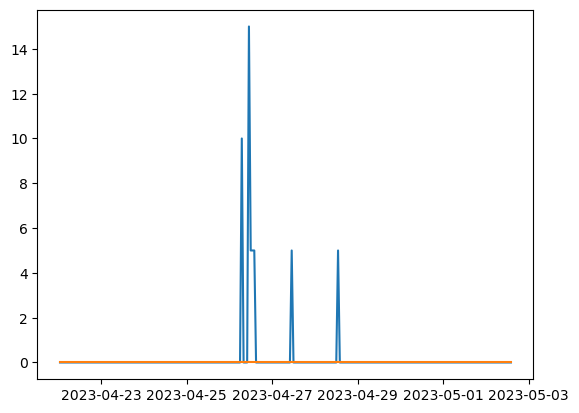

In [36]:
def synthetic_query(target, start, end):
    url = "https://portal.emcs.cornell.edu/api/datasources/proxy/5/query"
    data = {
        "range": {
            "from": start,
            "to": end,
        },
        "targets": [
            {
                "target": target
            }
        ],

    }
    request = requests.post(url, json=data)
    print(request)
    # print(request.json())
    master = create_tuple(request)
    list = pd.Series(data=[i[0] for i in master],
                     index=[i[1] for i in master])

    list = list[~list.index.duplicated()]

    return list

sash_data_occ = synthetic_query(target="Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.occ",
                                    start=str(datetime(2023, 4, 22)),
                                    end=str(datetime.now()))

sash_data_unocc = synthetic_query(target="Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.unocc",
                                      start=str(datetime(2023, 4, 22)),
                                      end=str(datetime.now()))

final_df = pd.DataFrame(
        data={"occ": sash_data_occ, "unocc": sash_data_unocc})
final_df = final_df.fillna(0)
final_df.index = final_df.index.map(lambda x: x.to_pydatetime().replace(tzinfo=tz.tzutc()).astimezone(tz.tzlocal()))
display(final_df)
plt.plot(final_df)